In [1]:
# External imports
import matplotlib.pyplot as plt
import pandas as pd

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


In [2]:
# Imports for experiment code
from src.data import load_dataset
from src.experiment import collect_wrong_indices, get_ternary_grader_data
from src.lib import DIFFICULTY_EASY, DIFFICULTY_HARD, DIFFICULTY_VERY_HARD
from src.models import *

#### Load up the dataset, split into train/test

The ID refers to the ID in the UCI database -- i.e., https://archive.ics.uci.edu/dataset/863/maternal+health+risk

In [3]:
dataset_id = 863
X, y = load_dataset(dataset_id)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print("Full dataset shape: ", X.shape)
print("Training set shape: ", X_train.shape)


Full dataset shape:  (1014, 6)
Training set shape:  (811, 6)


#### Train the glass box + black box models
- Glass box: A decision tree with up to depth 4
- Black box: XGBoost classifier, hyperparameters tuned via Optuna (250 trials)

In [4]:
glass_box = shallow_decision_tree_classifier()
glass_box.fit(X_train, y_train)
print('Glass box - Train accuracy: ', glass_box.score(X_train, y_train))
print('Glass box - Test accuracy:  ', glass_box.score(X_test, y_test))

black_box = OptunaXGBoostClassifier()
black_box.fit(X_train, y_train)

Glass box - Train accuracy:  0.7003699136868065
Glass box - Test accuracy:   0.6699507389162561


#### Collect "difficult" training patterns
We want to identify patterns that are,
- Classified correctly by the decision tree ("easy")
- Classified correctly by the random forest, but not the decision tree ("hard")
- Not correctly classified by either ("very hard")
    - This also includes the handful of patterns the decision tree gets right, but not XGBoost

We perform stratified k-fold (4-fold) cross validation on the training set -- i.e. it is split into sub-training (75%) and calibration (25%) data 4 times, with each pattern appearing in the calibration set once. Then, we collate all the patterns which were misclassified when they appeared in the calibration set.

We should expect that this should yield *roughly* (1 - (Testing Accuracy))% of the training set.

e.g. The testing accuracy of the black box is ~83%, so we can expect ~17% of the training set to get misclassified during the CV.  

In [5]:
glass_wrong_idx = collect_wrong_indices(shallow_decision_tree_classifier, X_train, y_train)
print('Ratio of indices "difficult" for glass box: ', len(glass_wrong_idx) / len(X_train))

Ratio of indices "difficult" for glass box:  0.3156596794081381


In [6]:
black_wrong_idx = collect_wrong_indices(OptunaXGBoostClassifier, X_train, y_train)
print('Ratio of indices "difficult" for black box: ', len(black_wrong_idx) / len(X_train))

Ratio of indices "difficult" for black box:  0.15906288532675708


In [7]:
#grader_x, grader_y = get_ternary_grader_data(glass_wrong_idx, black_wrong_idx, X_train, no_oversampling=True)
#print(grader_x.shape)
#print(X_train.shape)

Now sort these patterns into easy/hard/very hard

In [8]:
#np.bincount(grader_y) / len(X_train)

With oversampling...

In [9]:
grader_x, grader_y = get_ternary_grader_data(glass_wrong_idx, black_wrong_idx, X_train)
print(grader_x.shape)

(1665, 6)


In [10]:
np.bincount(grader_y)

array([555, 555, 555])

In [11]:
grader = medium_decision_tree_classifier()
grader.fit(grader_x, grader_y);

In [12]:
from sklearn.tree import plot_tree
from ucimlrepo import fetch_ucirepo 

uci_data = fetch_ucirepo(id=dataset_id)
column_names = uci_data.data.features.columns
print(column_names)
print(le.inverse_transform([0, 1, 2]))

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'], dtype='object')
['high risk' 'low risk' 'mid risk']


## The decision tree for the grader model

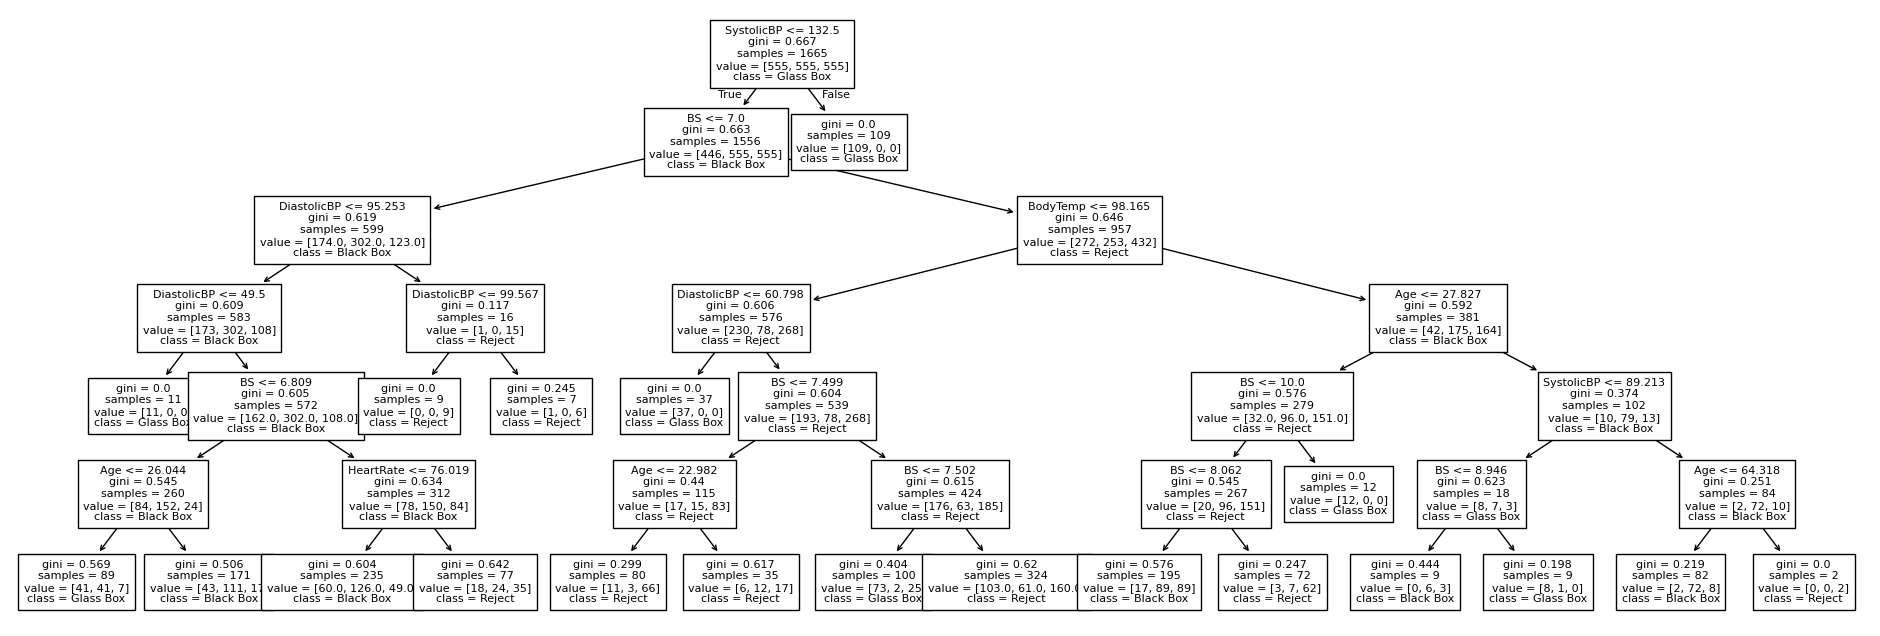

In [13]:
fig, ax = plt.subplots(figsize=(24, 8))
plot_tree(grader.best_estimator_, feature_names=column_names, class_names=['Glass Box', 'Black Box', 'Reject'], ax=ax, fontsize=8);
plt.show()

## The glass box decision tree

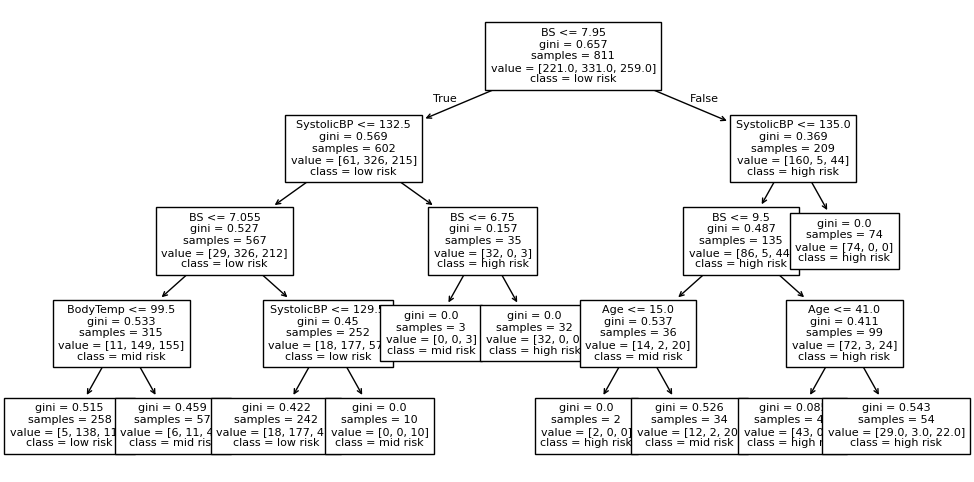

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_tree(glass_box.best_estimator_, feature_names=column_names, class_names=le.inverse_transform(np.arange(3)), ax=ax, fontsize=8)
plt.show()

In [15]:
from src.reporting import parse_results_df, text_report
df_train = pd.DataFrame(data={
    'y_truth': y_train,
    'y_glass': glass_box.predict(X_train),
    'y_black': black_box.predict(X_train),
    'y_grader': grader.predict(X_train),
})
df_test = pd.DataFrame(data={
    'y_truth': y_test,
    'y_glass': glass_box.predict(X_test),
    'y_black': black_box.predict(X_test),
    'y_grader': grader.predict(X_test),
})

In [16]:
print('---TRAIN---')
print(text_report(parse_results_df(df_train)))

---TRAIN---
  Pattern Allocation
|| Easy       || Hard       || Very Hard  ||
||----------------------------------------||
|| 40.69%     || 32.43%     || 26.88%     ||
||----------------------------------------||

  Accuracy
||            || Overall    || Easy       || Hard       || Very Hard  ||
||------------||------------||------------||------------||------------||
|| Hybrid     || 90.73%     || 89.70%     || 92.02%     || (N/A)      ||
|| Glass Box  || 70.04%     || 89.70%     || 46.77%     || 68.35%     ||
|| Black Box  || 93.34%     || 96.06%     || 92.02%     || 90.83%     ||
||------------||------------||------------||------------||------------||




In [17]:
print('---TEST---')
print(text_report(parse_results_df(df_test)))

---TEST---
  Pattern Allocation
|| Easy       || Hard       || Very Hard  ||
||----------------------------------------||
|| 39.41%     || 32.02%     || 28.57%     ||
||----------------------------------------||

  Accuracy
||            || Overall    || Easy       || Hard       || Very Hard  ||
||------------||------------||------------||------------||------------||
|| Hybrid     || 82.76%     || 78.75%     || 87.69%     || (N/A)      ||
|| Glass Box  || 67.00%     || 78.75%     || 49.23%     || 70.69%     ||
|| Black Box  || 82.27%     || 86.25%     || 87.69%     || 70.69%     ||
||------------||------------||------------||------------||------------||




In [18]:
black_box._model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.11359751570510745, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=60,
              max_leaves=None, min_child_weight=0.24451726198039025,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=None, n_jobs=None, num_parallel_tree=None, ...)